In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from tqdm import tqdm
sys.path.append('../Deep_Learning/')
from nn_optimization_methods import SGD
# from layers.Dense import Dense
from layers.Input import Input
sys.path.append('../tools/')
import tools

%matplotlib inline

## DNN from scratch

approximate sin function from random values.

In [3]:
x = np.linspace(-1, 1, 1000)

In [4]:
y = np.sin(x)**2

In [5]:
df = pd.DataFrame({'x':x,'y':y})

In [6]:
class Dense():
    """
    Dense Layer used for the DNN object
    Parameters:
        weights: numpy array() weight matrix
        output: output of the layer
        deriv: derivative of activation
        activation_name: name of activation, used to print
        activation: activation functions
        shape: output shape
        prevlayer: previous layer
        next: next layer
    """
    
    def __init__(self,prevlayer,outputdims,activation="sigmoid"):
        
        self.weights = [np.random.uniform(-1,1,size=(prevlayer.shape[1],outputdims)),np.random.uniform(-1,1,size=(1,outputdims))]
        self.output = 0
        self.deriv = 1
        self.activation_name = activation
        self.activation = None
        self.print_shape = (None,outputdims)
        self.shape = (prevlayer.shape[1],outputdims)
        self.prevlayer = prevlayer
        self.next = None
        
        if activation == "sigmoid":
            self.activation = tools.sigmoid
            
        elif activation == "linear":
            self.activation = self.linear
        
    def getWeights(self):
        
        return self.weights
    
    def setNext(self,layer):
        
        self.next = layer
        
    def getNext(self):
        
        return self.next
    
    def getPrev(self):
        
        return self.prevlayer
        
    def dot(self,X,t=False):
        
        if t == True:
            return self.output.T.dot(X)
        return self.output.dot(X)
        
    def foward(self):
        
        layer_mul = self.prevlayer.dot(self.weights[0]) + self.weights[1]
        self.output = self.activation(layer_mul)
        self.deriv = self.activation(layer_mul,True)
    
    def predict(self,X):
        
        return self.activation(X.dot(self.weights[0]) + self.weights[1])
        
    def update(self,X):

        self.weights = X
        
    def linear(self,X,deriv=False):
        
        if deriv == True:
            return 1
        else:
            return X
        
    def __repr__(self):
        
        string = "Dense: " + "activation: " + self.activation_name +  ", weight shape: " + str(self.weights[0].shape) + ", output shape: " + str(self.print_shape)
        string = string + ", parameters: " + str(self.weights[0].shape[0]*self.weights[0].shape[1])
        string = string + '\n' + "-----------------------------------------------------------------" + '\n'
        return string  
    
    def __str__(self):
        
        string = "Dense: " + "activation: " + self.activation_name +  ", weight shape: " + str(self.weights[0].shape) + ", output shape: " + str(self.print_shape)
        string = string + ", parameters: " + str(self.weights[0].shape[0]*self.weights[0].shape[1])
        string = string + '\n' + "-----------------------------------------------------------------" + '\n'
        return string  

In [7]:
class DNN():
    
    """
    Deep Neural Network Template for regression and classification tasks
    Parameters:
        X: numpy array() data matrix
        y: numpy array() response variables, must be numeric
        output: numpy array() outputs
        outlayer = output layer
        head = input layer
    
    Use like sequential model from Keras:
        Ex: add a dense layer with 200 neurons and a sigmoid activation function:
                dnn.add("dense","sigmoid",200)
    """
    def __init__(self,X,y):
            
        self.X = X
        self.y = y
        self.output = 0
        self.outlayer = Input(self.X)
        self.head = self.outlayer
    
    def add(self,layertype,activation,neurons):
        
        if layertype == "dense":
                layer = Dense(self.outlayer,neurons,activation)
                self.outlayer.setNext(layer)
                self.outlayer = layer
            
    def foward(self,inputs=None):
        
        if np.all(inputs != None):
            
            self.head.update(inputs)
            
        layer = self.head
        
        while np.all(layer.next != None):
            
            layer.foward()
            layer = layer.getNext()
        
        layer.foward()
        return layer.output
        
    def backward_pass(self,predictions,y,loss="MSE"):
        
        cache = 0
        gradients = []
        
        if loss == "MSE":
            
            layer = self.outlayer
            cache = np.array(np.sum(predictions - y))
            w_derivative = layer.getPrev().dot(cache*(layer.deriv),True)
            b_derivative = cache*(layer.deriv)
            gradients.append([w_derivative,b_derivative])
            layer = layer.getPrev()
            while np.all(layer.getPrev() != None):
                cache = (cache.dot(layer.getNext().getWeights()[0].T))*layer.deriv
                w_derivative = layer.getPrev().dot(cache,True)
                b_derivative = cache
                gradients.append([w_derivative,b_derivative])
                layer = layer.getPrev()
            
            return gradients[::-1]
        
    def train(self,X,y,optimizer=SGD,lr=0.0001,epochs=100,batch_size=1):
        
        optimizer(self,X,y,learning_rate=lr,epochs=epochs,batch_size=batch_size)
        
    def predict(self,X):
        
        return self.foward(X)
        
    def __str__(self):
        
        string = "----------------------------- Model -----------------------------" + '\n'
        layer = self.head
        
        while np.all(layer != None):
            string += layer.__str__()
            layer = layer.getNext()
            
        return string

In [8]:
x = x.reshape(x.shape[0],1)
dnn = DNN(x,y)
dnn.add("dense","sigmoid",24)
dnn.add("dense","sigmoid",48)
dnn.add("dense","sigmoid",16)
dnn.add("dense","linear",1)
print(dnn)

----------------------------- Model -----------------------------
Input: shape: (None, 1)
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (1, 24), output shape: (None, 24), parameters: 24
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (24, 48), output shape: (None, 48), parameters: 1152
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (48, 16), output shape: (None, 16), parameters: 768
-----------------------------------------------------------------
Dense: activation: linear, weight shape: (16, 1), output shape: (None, 1), parameters: 16
-----------------------------------------------------------------



In [9]:
dnn.train(x,y,lr=0.001,epochs=1000)

MSE 2.1577826410476682e-05: 100%|██████████| 1000/1000 [12:18<00:00,  1.35it/s]


In [10]:
predictions = dnn.predict(x)

In [11]:
predictions = predictions.reshape(predictions.shape[0],)

In [12]:
newd = pd.DataFrame({'x':df["x"],'y':predictions})

In [14]:
df["y"][:20]

0     0.708073
1     0.706251
2     0.704426
3     0.702597
4     0.700765
5     0.698930
6     0.697092
7     0.695250
8     0.693406
9     0.691558
10    0.689707
11    0.687854
12    0.685997
13    0.684137
14    0.682274
15    0.680408
16    0.678540
17    0.676668
18    0.674794
19    0.672917
Name: y, dtype: float64

In [13]:
newd["y"][:20]

0     0.695653
1     0.693988
2     0.692320
3     0.690649
4     0.688974
5     0.687297
6     0.685617
7     0.683934
8     0.682247
9     0.680558
10    0.678866
11    0.677170
12    0.675472
13    0.673771
14    0.672067
15    0.670360
16    0.668650
17    0.666937
18    0.665221
19    0.663502
Name: y, dtype: float64

Predicted after 1000 epochs

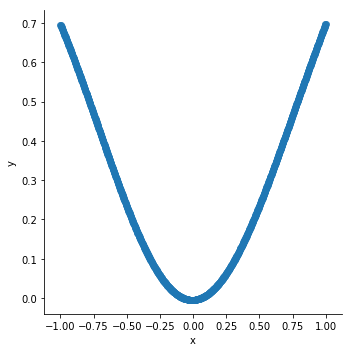

In [15]:
sns.lmplot(x='x', y='y',data=newd,
           fit_reg=False, # No regression line
          )  

Original sin wave

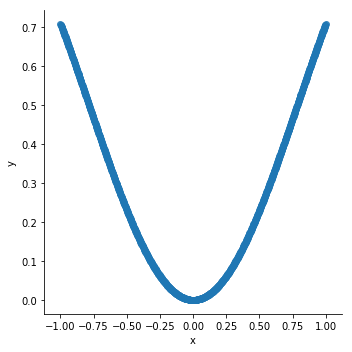

In [16]:
sns.lmplot(x='x', y='y',data=df,
           fit_reg=False, # No regression line
          )   